<a href="https://colab.research.google.com/github/PKohli876/Machine-Learning---Time-Series-project/blob/main/Time_Series_ML_Intermediate_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%time
!pip install -q datascience                                         # Package that is required by pandas profiling
!pip install -q pandas-profiling     

!pip install -q --upgrade pandas-profiling
!pip install -q --upgrade statsmodels 

CPU times: user 66.4 ms, sys: 37.3 ms, total: 104 ms
Wall time: 11.3 s


In [3]:
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd
from pandas_profiling import ProfileReport                          # Import Pandas Profiling (To generate Univariate Analysis)
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clearity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('mode.chained_assignment', None)                      # Removing restriction over chained assignments operations
pd.set_option('display.float_format', lambda x: '%.5f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
from datetime import datetime                                       # Importing datetime for datetime manipulation
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration
import seaborn as sns                                               # Importin seaborm library for interactive visualization
%matplotlib inline
#-------------------------------------------------------------------------------------------------------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose             # Seasonal decomposition using moving averages
from statsmodels.tsa.stattools import adfuller                      # Augmented Dickey-Fuller unit root test
from statsmodels.tsa.stattools import acf, pacf                     # Importing Autocorrelation and Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf                  # To plot Autocorrelation Function
from statsmodels.graphics.tsaplots import plot_pacf                 # To plot Partial Autocorrelation Function
#-------------------------------------------------------------------------------------------------------------------------------
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once

In [127]:
# import data
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv')
# Review data
print('Data Shape:', data.shape)
data.head()

Data Shape: (365, 2)


,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [128]:
# Review metadata
print('Described Column Length:', len(data.describe().columns))
data.describe().transpose()


Described Column Length: 1


,count,mean,std,min,25%,50%,75%,max
Births,365.00000,41.98082,7.34826,23.00000,37.00000,42.00000,46.00000,73.00000


In [129]:
data.info(verbose=True, memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 26.9 KB


No Null values. Date object needs to be converted to datetime

In [130]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Births  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB
None


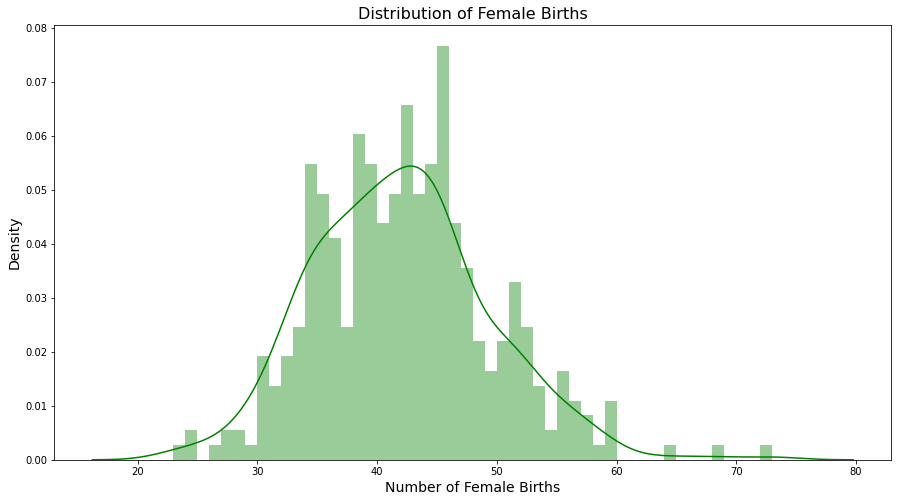

In [131]:
# Created a new figure of 15 X 8 inches
fig = plt.figure(figsize=[15, 8])
sns.distplot(a=data['Births'], bins=50, color='green')
plt.title(label='Distribution of Female Births', size=16)
plt.xlabel(xlabel='Number of Female Births', size=14)
plt.ylabel(ylabel='Density', size=14)
plt.show()

Distribution can be considered normal


Time Series Analysis
Time series deals with two columns, i.e. temporal (predictor) and forecast (prediction).

Temporal: The time which in our case is Month.

Forecast: The number of female births 

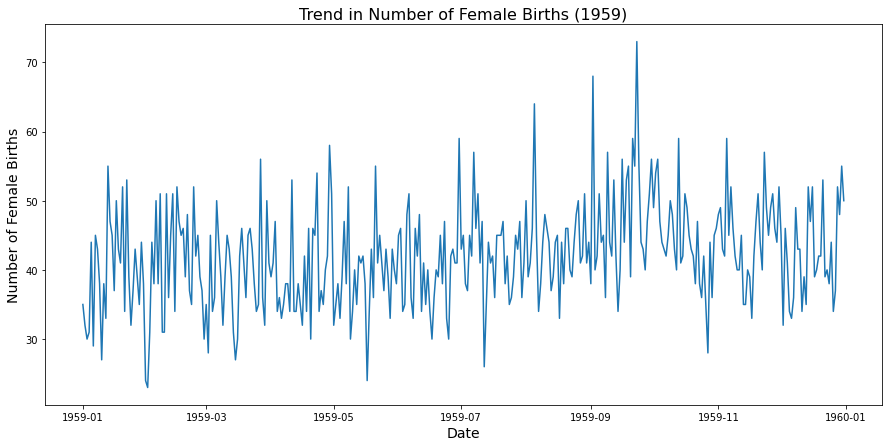

In [132]:
fig = plt.figure(figsize=[15, 7])
sns.lineplot(x='Date', y='Births', data=data)
plt.xlabel(xlabel='Date', size=14)
plt.ylabel(ylabel='Number of Female Births', size=14)
plt.title(label='Trend in Number of Female Births (1959)', size=16)
plt.show()

Decomposition Of Time Series
It is referred as decomposition of a time series into following components:

Seasonal Component,
Trend Component,
Cyclic Component and,
Irregular or Reisdual Component
These componentst are plotted separately.

The cyclical component (if present in the data) is included in the "trend" component plot.

Success!


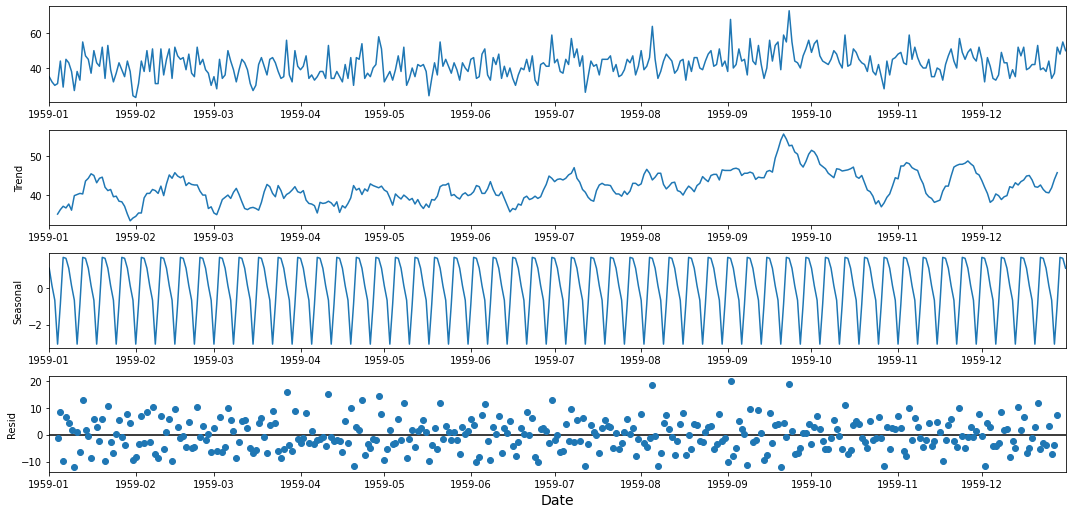

In [133]:
indexed_data =  data.set_index(['Date'])
print('Success!')
# Set figsize of 15 X 7 inches
rcParams['figure.figsize']  =  [15, 7]

# Decomposed data into respective components: Observed, Trend, Seasonal and Residual
seasonal_decompose(x=indexed_data, model='additive', extrapolate_trend=0).plot()
plt.xlabel(xlabel='Date', size = 14)
plt.show()

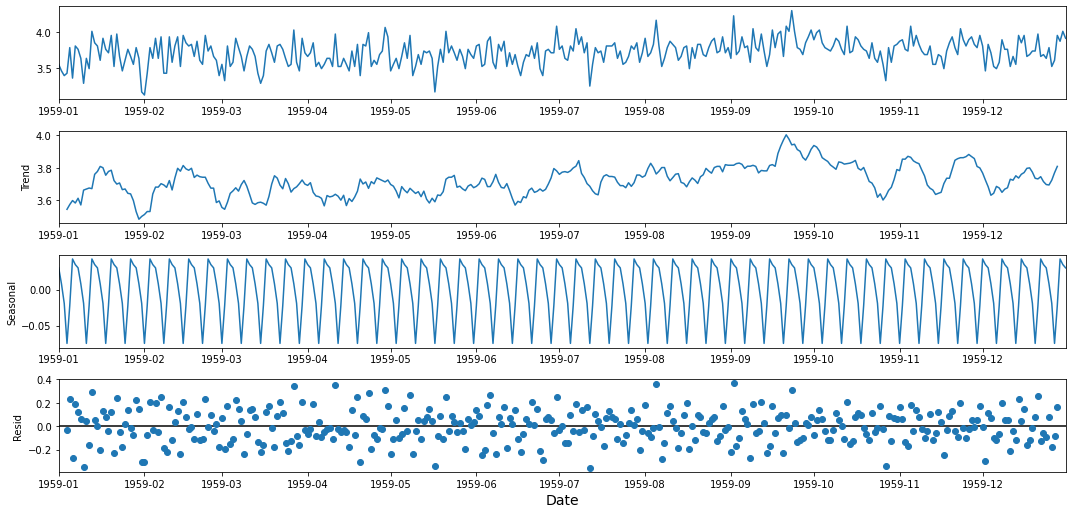

In [134]:
# Applied Log Transformation
log_indexed_data = np.log(indexed_data)
seasonal_decompose(x=log_indexed_data, model='additive', extrapolate_trend=0).plot()
# seasonal_decompose(x=indexed_data, model='multiplicative', extrapolate_trend=0).plot() will yield same results
# but we will need two versions of data additive and multiplicatve for checking stationary test of ADF. Whichveer decomposition yields 
# staionary results, will be used
plt.xlabel(xlabel='Date', size = 14)
plt.show()

Define Functions for stationary checks:
1. Constant Mean
2. Constant variance
3. Auto-corelation is independenct of time

In [135]:
# Function rolling means : To check and view mean and variance visually
def rolling_means(data, dataColumn, title_add = ''):

  # Average rolling mean over 12 months over the entire data set
  roll_mean = data.rolling(window=12).mean()

  # Plotting Rolling Statistics over Observed Data
  roll_std = data.rolling(window=12).std()

  sns.lineplot(x=data.index, y=dataColumn, data=data)
  sns.lineplot(x=roll_mean.index, y=dataColumn, data=roll_mean)
  sns.lineplot(x=roll_std.index, y=dataColumn, data=roll_std)

  plt.legend(labels=['Observed', 'Rolling Mean', 'Rolling Std'], loc='best', prop = {'size': 14})
  plt.xlabel(xlabel='Month', size=14)
  plt.ylabel(ylabel='Number of Female Births', size=14)
  plt.title(label='Rolling Statistics (μ & σ)' + title_add, size=16)

# Function Augumented Dicky-Fuller Test  : To evaluate Hypotheses accpetance/rejection with 1,5,10% confidences
def ADFTest(data, dataColumn, test_label='Original'):

  # Saved test results from adfuller function
  dftest = adfuller(data[dataColumn], autolag='AIC')

  # Extracted respective values from the saved test results
  df_dict = {'ADF_Test_Statistics': dftest[0], 'p-value': dftest[1], 'Used_Lags': dftest[2], 
              'Number_Of_Observations': dftest[3], 'Critical_Value (1%)': dftest[4]['1%'],
            'Critical_Value (5%)': dftest[4]['5%'], 'Critical_Value (10%)': dftest[4]['10%']}

  # Created dataframe out of the dictionary
  dfoutput = pd.DataFrame(data=df_dict, index=[test_label])

  return dfoutput

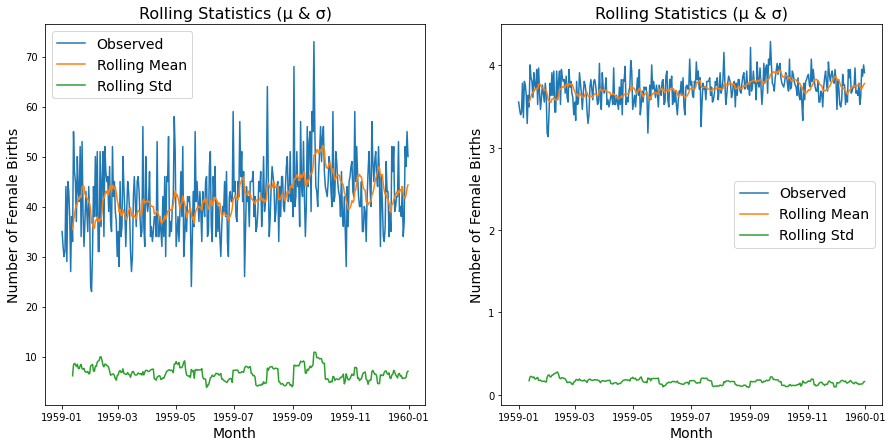

In [136]:
# Plotting Rolling Statistics over Observed Data for logindexed data
figure = plt.figure(figsize=[15, 7])
plt.subplot(1, 2, 1)

# Called the function
rolling_means(indexed_data, 'Births')

plt.subplot(1, 2, 2)

rolling_means(log_indexed_data, 'Births')

# Plot the Visual
plt.show()

In [137]:
d1 = ADFTest(indexed_data,'Births')
d2 = ADFTest(log_indexed_data,'Births','Log Data')
motaData = pd.concat([d1, d2])
motaData



,ADF_Test_Statistics,p-value,Used_Lags,Number_Of_Observations,Critical_Value (1%),Critical_Value (5%),Critical_Value (10%)
Original,-4.80829,0.00005,6,358,-3.44875,-2.86965,-2.57109
Log Data,-4.35317,0.00036,7,357,-3.44880,-2.86967,-2.57110


Observations:

From the above graphs (original, log transformed) it is clearly visible that rolling mean is not stationary and original is better than log tarnsformed.

Test statistics is negative but p-value is greater than 0.01, 0.05 and 0.1.

Our Critical values are also far away from Test Statistics.

We would need another transformation which is called as Scaled Moving Average.

We will abandon log_indexed_data from now on it is indicative that the time series is closer to additive nature than multiplicative. For any other transformations, indexed_data will be used



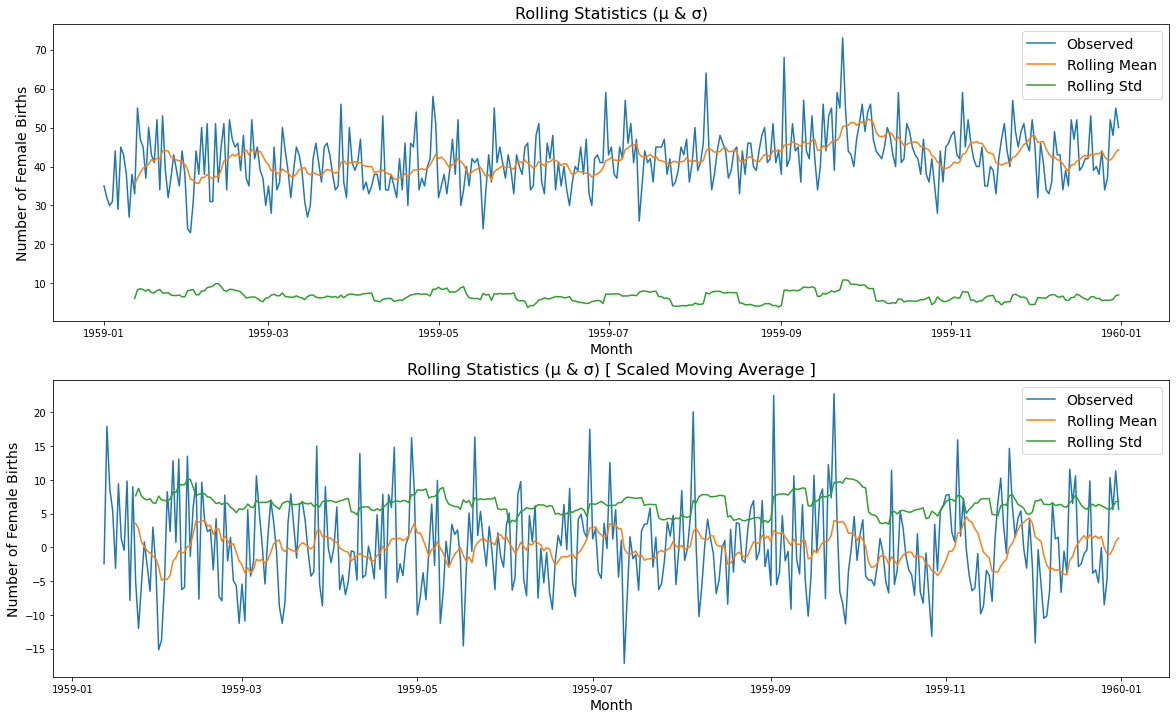

In [138]:
# Scaled Moving Avergae Data
moving_average_indexed_data = indexed_data.rolling(window=12).mean()
scaled_moving_average = indexed_data - moving_average_indexed_data

# Remove NAN values
scaled_moving_average.dropna(inplace=True)

figure = plt.figure(figsize=[20, 12])

# Plot With Scaled Moving Average
# Plot the Visual
plt.subplot(2, 1, 1)

# Called the function
rolling_means(indexed_data, 'Births')

plt.subplot(2, 1, 2)

rolling_means(scaled_moving_average, 'Births', title_add=' [ Scaled Moving Average ]')

# Plot the Visual
plt.show()

# Display top 12 data pointsscaled_moving_average.head(12).transpose()

In [139]:
d_movingaverage = ADFTest(scaled_moving_average,'Births', 'Moving Average')
motaData = pd.concat([motaData, d_movingaverage])
motaData

,ADF_Test_Statistics,p-value,Used_Lags,Number_Of_Observations,Critical_Value (1%),Critical_Value (5%),Critical_Value (10%)
Original,-4.80829,0.00005,6,358,-3.44875,-2.86965,-2.57109
Log Data,-4.35317,0.00036,7,357,-3.44880,-2.86967,-2.57110
Moving Average,-7.82270,0.00000,12,341,-3.44967,-2.87005,-2.57131


We can see that moving average has imporved and p value decreased , but we have a long way to go. We will keep on evaluating more methods till we achieve stationary data

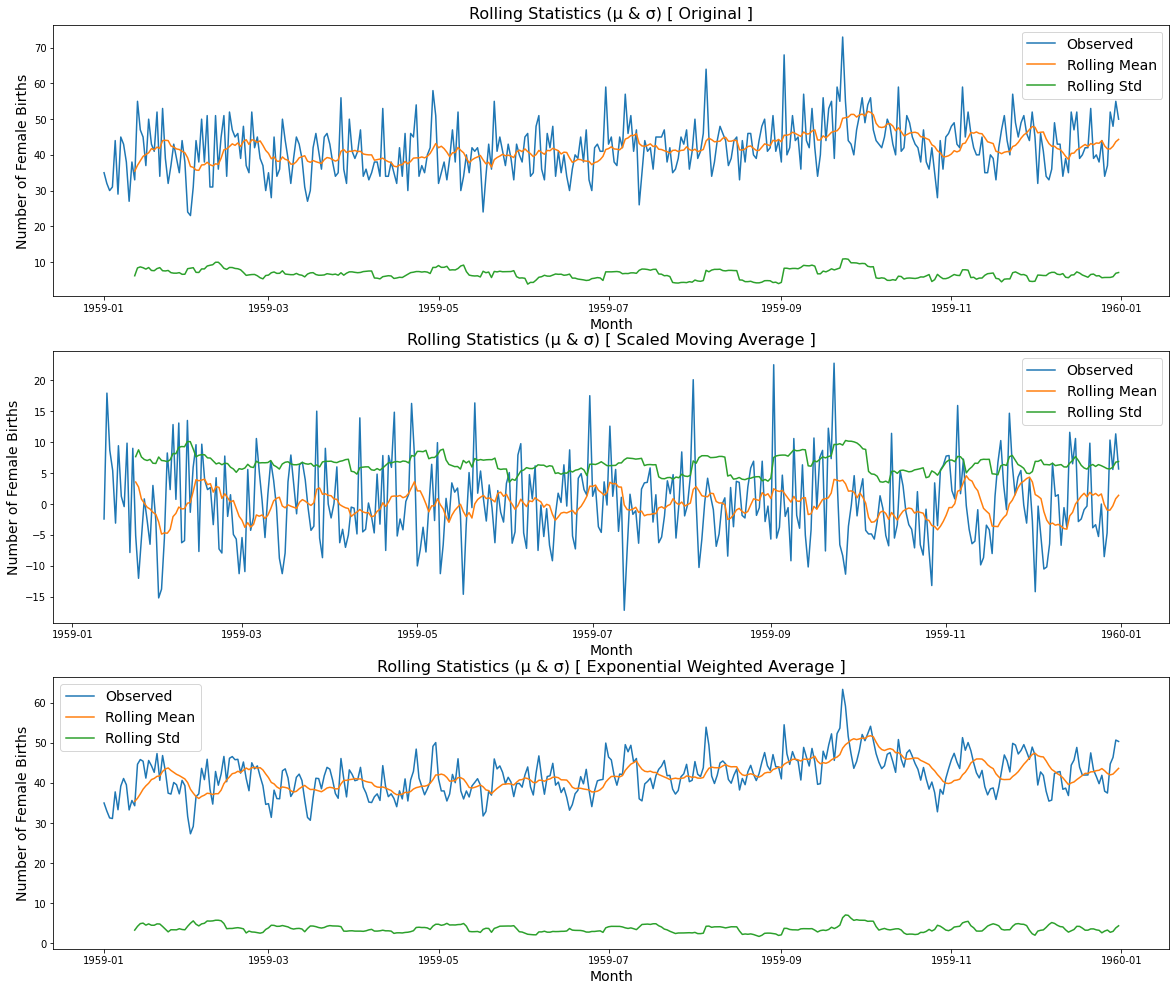

In [140]:
# Plotting Rolling Statistics over Observed Data
figure = plt.figure(figsize = [20, 17])

plt.subplot(3, 1, 1)

# Plot Without Transformation
rolling_means(indexed_data, 'Births',title_add = ' [ Original ]')

plt.subplot(3, 1, 2)

rolling_means(scaled_moving_average, 'Births', title_add=' [ Scaled Moving Average ]')


plt.subplot(3, 1, 3)

# Apply Exponential Weight Transformation
exp_weighted_avg_indexed_data = indexed_data.ewm(alpha = 0.5, min_periods = 0, adjust = True).mean()

# Plot With Log Transformation
rolling_means(exp_weighted_avg_indexed_data,'Births', title_add = ' [ Exponential Weighted Average ]')

# Plot the Visual
plt.show()

# Display top 12 data points
#exp_weighted_avg_indexed_data.head(12).transpose()

In [141]:
d_exp_weighted_avg = ADFTest(exp_weighted_avg_indexed_data,'Births', 'Exponential Moving Average')
motaData = pd.concat([motaData, d_exp_weighted_avg])
motaData

,ADF_Test_Statistics,p-value,Used_Lags,Number_Of_Observations,Critical_Value (1%),Critical_Value (5%),Critical_Value (10%)
Original,-4.80829,0.00005,6,358,-3.44875,-2.86965,-2.57109
Log Data,-4.35317,0.00036,7,357,-3.44880,-2.86967,-2.57110
Moving Average,-7.82270,0.00000,12,341,-3.44967,-2.87005,-2.57131
Exponential Moving Average,-8.02285,0.00000,0,364,-3.44844,-2.86951,-2.57102


We can see that exp moving average has imporved Test stats , but we still have a long way to go. We will keep on evaluating more methods till we achieve stationary data


In [ ]:
##TODO : Correct above text. Understand ADF Test and correct comments. Data is stationary in all 4.
##Do 1 or 2 more technichines before moving to ACF and PCAF and then predictions